In [1]:
# SETUP

import os
import traceback
import numpy as np
import time
import matplotlib.pyplot as plt
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.quality_evaluation_ import hyperbolic_nearest_neighbor_preservation


data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.MNIST  # the Datasets handler provides access to several data sets used throughout the repository
perp = 15  # we use a perplexity of 30 in this example
logging = True

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


In [2]:

def run(num_points = 1000, exact=False, use_uniform_grid=False, uniform_grid_n=10):
    global logging
    global log_path

    dataX, dataLabels, D, V, _ = load_data(
        dataset, 
        data_home=data_home, 
        random_state=seed, 
        to_return="X_labels_D_V",
        hd_params={"perplexity": perp}, 
        sample=num_points, 
        knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
    )

    print("Loading data")

    start_time = time.time()


    end_time = time.time()

    execution_time = end_time - start_time
    print("Data loading:", execution_time, "seconds")

    exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
    ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
    main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.



    # ============= RUNNING =============

    opt_config = dict(
        learning_rate_ex=learning_rate,  # learning rate during exaggeration
        learning_rate_main=learning_rate,  # learning rate main optimization 
        exaggeration=exaggeration_factor, 
        exaggeration_its=ex_iterations, 
        gradientDescent_its=main_iterations, 
        vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
        momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
        momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
        exact=exact,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
        area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
        n_iter_check=10,  # Needed for early stopping criterion
        size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
        uniform_grid_n = uniform_grid_n,
        use_uniform_grid = use_uniform_grid
    )

    opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

    #print("Sequence defined")

    # Start: configure logging
    if logging:
        logging_dict = {
            "log_path": log_path
        }
        opt_params["logging_dict"] = logging_dict

        log_path = opt_params["logging_dict"]["log_path"]
        # Delete old log path
        if os.path.exists(log_path) and not only_animate:
            import shutil
            shutil.rmtree(log_path)
    # End: logging

    # Compute an initial embedding of the data via PCA
    X_embedded = initialization(
        n_samples=dataX.shape[0],
        n_components=2,
        X=dataX,
        random_state=seed,
        method="pca"
    )

    # Initialize the embedder
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed", 
        verbose=True, 
        opt_method=SequentialOptimizer, 
        opt_params=opt_params
    )

    start_time = time.time()

    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
    except ValueError:
        print("Error!")
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    end_time = time.time()

    execution_time = end_time - start_time
    if exact:
        if use_uniform_grid:
            print(f"[CPU Exact, n={num_points}] Execution time:", execution_time, "seconds")
        else:
            print(f"[GPU Exact, n={num_points}] Execution time:", execution_time, "seconds")
    elif use_uniform_grid:
        print(f"[UGrid, n={num_points}, grid_n={uniform_grid_n}] Execution time:", execution_time, "seconds")
    else:
        print(f"[QTree, n={num_points}] Execution time:", execution_time, "seconds")

        
    _, precisions, recalls, _ = hyperbolic_nearest_neighbor_preservation(
        dataX,
        hyperbolicEmbedding,
        k_start=1,
        k_max=30,
        D_X=None,
        exact_nn=True,
        consider_order=False,
        strict=False,
        to_return="full"
    )

    print(f"Precision: {precisions}, recall: {recalls}")

    # Create a rendering of the embedding and save it to a file
    if not os.path.exists("results"):
        os.mkdir("results")
    fig = plot_poincare(hyperbolicEmbedding, dataLabels)
    fig.show()
    fig.savefig(f"results/{dataset.name}-inexact.png")

    return precisions, recalls, execution_time

Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97338 grad_norm: 2.18523e+00: 100%|██████████| 250/250 [00:12<00:00, 20.57it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.57477 grad_norm: 1.36810e+01:  63%|██████▎   | 469/750 [00:21<00:12, 21.73it/s]


4
[GPU Exact, n=1000] Execution time: 33.74331307411194 seconds
Precision: [0.82, 0.804, 0.7903333333333332, 0.7715, 0.7492000000000001, 0.7311666666666666, 0.7115714285714285, 0.698, 0.6802222222222222, 0.6687000000000001, 0.6545454545454545, 0.645, 0.6324615384615384, 0.619, 0.6075333333333333, 0.5949375, 0.5836470588235294, 0.5720555555555555, 0.5621052631578948, 0.5509000000000001, 0.540952380952381, 0.5315, 0.5210434782608695, 0.51075, 0.50112, 0.4918461538461538, 0.4840740740740741, 0.47617857142857145, 0.46551724137931033, 0.4570333333333333], recall: [0.027333333333333328, 0.053599999999999995, 0.07903333333333333, 0.10286666666666668, 0.12486666666666667, 0.14623333333333333, 0.16603333333333334, 0.18613333333333332, 0.2040666666666667, 0.2229, 0.24, 0.258, 0.2740666666666667, 0.28886666666666666, 0.30376666666666663, 0.3173, 0.3307333333333333, 0.34323333333333333, 0.356, 0.36726666666666663, 0.37866666666666665, 0.38976666666666665, 0.39946666666666664, 0.40859999999999996, 

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97464 grad_norm: 2.19959e+00: 100%|██████████| 250/250 [00:08<00:00, 28.15it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.64658 grad_norm: 1.70531e+02:  55%|█████▍    | 409/750 [00:14<00:12, 27.43it/s]


4
[CPU Exact, n=1000] Execution time: 23.80027985572815 seconds
Precision: [0.815, 0.798, 0.784, 0.7715, 0.751, 0.7326666666666666, 0.715, 0.70375, 0.6886666666666668, 0.6739, 0.6605454545454545, 0.6461666666666667, 0.6336923076923078, 0.6220714285714286, 0.6086666666666666, 0.595, 0.5845294117647059, 0.5751111111111111, 0.564, 0.555, 0.5432380952380952, 0.5326818181818181, 0.5224782608695653, 0.5114583333333333, 0.50144, 0.49330769230769234, 0.48474074074074075, 0.47757142857142854, 0.4688275862068966, 0.45926666666666666], recall: [0.027166666666666665, 0.0532, 0.07840000000000001, 0.10286666666666668, 0.12516666666666668, 0.14653333333333332, 0.16683333333333333, 0.18766666666666668, 0.2066, 0.22463333333333335, 0.2422, 0.2584666666666667, 0.27459999999999996, 0.29029999999999995, 0.3043333333333333, 0.3173333333333333, 0.3312333333333333, 0.3450666666666667, 0.35719999999999996, 0.37, 0.38026666666666664, 0.39063333333333333, 0.4005666666666667, 0.4091666666666666, 0.41786666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99712 grad_norm: 2.19447e+00: 100%|██████████| 250/250 [00:06<00:00, 37.21it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.65562 grad_norm: 1.30116e+01:  52%|█████▏    | 389/750 [00:09<00:08, 42.28it/s]


4
[UGrid, n=1000, grid_n=40] Execution time: 15.92941951751709 seconds
Precision: [0.826, 0.8025, 0.7866666666666666, 0.7655, 0.75, 0.7338333333333333, 0.716, 0.701125, 0.6871111111111111, 0.6708999999999999, 0.6557272727272727, 0.6421666666666668, 0.6290769230769231, 0.6152142857142858, 0.6032000000000001, 0.5916875, 0.5814117647058823, 0.5683888888888889, 0.556, 0.5462, 0.5381428571428571, 0.5296818181818183, 0.522391304347826, 0.514375, 0.50548, 0.49761538461538457, 0.4902222222222222, 0.4801428571428571, 0.4721724137931035, 0.46613333333333334], recall: [0.02753333333333333, 0.0535, 0.07866666666666668, 0.10206666666666667, 0.125, 0.14676666666666666, 0.16706666666666667, 0.18696666666666667, 0.20613333333333334, 0.22363333333333332, 0.24043333333333333, 0.2568666666666667, 0.27259999999999995, 0.2871, 0.30160000000000003, 0.31556666666666666, 0.32946666666666663, 0.3410333333333333, 0.3521333333333333, 0.3641333333333333, 0.3767, 0.38843333333333335, 0.4005, 0.4115, 0.421233333333

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97337 grad_norm: 2.17491e+00: 100%|██████████| 250/250 [00:09<00:00, 27.04it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.65021 grad_norm: 5.38000e+00:  55%|█████▍    | 409/750 [00:13<00:11, 30.27it/s]


4
[QTree, n=1000] Execution time: 22.765940189361572 seconds
Precision: [0.794, 0.7775, 0.7646666666666666, 0.753, 0.7392000000000001, 0.7246666666666668, 0.7097142857142856, 0.69575, 0.6814444444444444, 0.6635, 0.6484545454545455, 0.6374166666666666, 0.625, 0.6120714285714287, 0.5986666666666668, 0.5879375, 0.5805882352941176, 0.5705555555555556, 0.5606842105263158, 0.54975, 0.5396190476190476, 0.5288636363636363, 0.5191304347826088, 0.5106666666666666, 0.50156, 0.49173076923076925, 0.482, 0.4719642857142857, 0.46337931034482754, 0.45603333333333335], recall: [0.026466666666666666, 0.05183333333333333, 0.07646666666666667, 0.1004, 0.12320000000000002, 0.14493333333333333, 0.16560000000000002, 0.18553333333333333, 0.20443333333333333, 0.22116666666666668, 0.23776666666666668, 0.2549666666666666, 0.27083333333333337, 0.28563333333333335, 0.2993333333333334, 0.31356666666666666, 0.329, 0.3423333333333334, 0.3551, 0.3665, 0.37773333333333337, 0.3878333333333333, 0.398, 0.4085333333333333,

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42551 grad_norm: 1.09831e+00: 100%|██████████| 250/250 [01:43<00:00,  2.41it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.86015 grad_norm: 4.42986e-01:  44%|████▍     | 329/750 [02:13<02:50,  2.47it/s]


4
[GPU Exact, n=4000] Execution time: 236.99092507362366 seconds
Precision: [0.655, 0.627, 0.6040833333333333, 0.588625, 0.574, 0.561, 0.5492142857142857, 0.53675, 0.5259166666666666, 0.514575, 0.5047272727272727, 0.49575, 0.4864230769230769, 0.4781071428571429, 0.46953333333333336, 0.46190625, 0.4543088235294117, 0.44711111111111107, 0.44011842105263155, 0.4338, 0.42740476190476195, 0.42109090909090907, 0.4152282608695652, 0.4094895833333333, 0.4035300000000001, 0.3975480769230769, 0.3924259259259259, 0.38717857142857137, 0.3821379310344828, 0.37710000000000005], recall: [0.021833333333333333, 0.0418, 0.060408333333333335, 0.07848333333333334, 0.09566666666666669, 0.11220000000000001, 0.12815000000000004, 0.14313333333333336, 0.15777500000000003, 0.171525, 0.18506666666666666, 0.1983, 0.21078333333333332, 0.22311666666666669, 0.23476666666666668, 0.24634999999999999, 0.2574416666666667, 0.26826666666666665, 0.27874166666666667, 0.2892, 0.29918333333333336, 0.30879999999999996, 0.31834

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42631 grad_norm: 1.10224e+00: 100%|██████████| 250/250 [00:29<00:00,  8.53it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.73361 grad_norm: 2.50246e+00:  51%|█████     | 379/750 [00:46<00:45,  8.12it/s]


4
[CPU Exact, n=4000] Execution time: 75.98997068405151 seconds
Precision: [0.65225, 0.62775, 0.6075833333333333, 0.59725, 0.58465, 0.571875, 0.56, 0.54771875, 0.5365555555555555, 0.526125, 0.5159772727272728, 0.5062083333333333, 0.49678846153846157, 0.48844642857142856, 0.47928333333333334, 0.47125, 0.4631617647058824, 0.45531944444444444, 0.44736842105263164, 0.4395625, 0.4327857142857143, 0.4265681818181818, 0.4205, 0.4144375, 0.40892000000000006, 0.40303846153846157, 0.39770370370370367, 0.39174107142857145, 0.3870172413793104, 0.38123333333333337], recall: [0.021741666666666666, 0.04184999999999999, 0.060758333333333324, 0.07963333333333332, 0.09744166666666666, 0.114375, 0.13066666666666668, 0.14605833333333335, 0.1609666666666667, 0.175375, 0.18919166666666667, 0.20248333333333335, 0.21527499999999997, 0.22794166666666665, 0.23964166666666667, 0.2513333333333333, 0.2624583333333333, 0.27319166666666667, 0.2833333333333333, 0.2930416666666667, 0.30295000000000005, 0.3128166666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42684 grad_norm: 1.09822e+00: 100%|██████████| 250/250 [00:16<00:00, 15.43it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.02805 grad_norm: 2.79879e+00:  35%|███▍      | 259/750 [00:15<00:28, 17.02it/s]


4
[UGrid, n=4000, grid_n=40] Execution time: 31.430526733398438 seconds
Precision: [0.622, 0.60525, 0.586, 0.5715625, 0.55675, 0.5395416666666667, 0.5270357142857143, 0.51625, 0.5051944444444445, 0.495725, 0.48399999999999993, 0.4745, 0.46626923076923077, 0.45875, 0.4503666666666667, 0.44328125, 0.43607352941176475, 0.42884722222222227, 0.4222236842105263, 0.4157125, 0.4096666666666666, 0.4039545454545454, 0.3979130434782609, 0.39230208333333333, 0.3871800000000001, 0.3813269230769231, 0.37663888888888886, 0.37167857142857147, 0.3672844827586207, 0.36273333333333335], recall: [0.020733333333333333, 0.04035, 0.05859999999999999, 0.07620833333333332, 0.09279166666666668, 0.10790833333333334, 0.12297500000000003, 0.1376666666666667, 0.15155833333333335, 0.16524166666666668, 0.17746666666666666, 0.18980000000000002, 0.20205, 0.21408333333333335, 0.22518333333333335, 0.23641666666666666, 0.24710833333333335, 0.25730833333333336, 0.2674083333333333, 0.2771416666666667, 0.28676666666666667, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.43023 grad_norm: 1.09633e+00: 100%|██████████| 250/250 [00:34<00:00,  7.28it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.89919 grad_norm: 6.66936e-01:  43%|████▎     | 319/750 [00:39<00:53,  8.10it/s]


4
[QTree, n=4000] Execution time: 73.74156284332275 seconds
Precision: [0.631, 0.607875, 0.5918333333333332, 0.57825, 0.5658, 0.5502083333333334, 0.5371071428571429, 0.5264375, 0.516888888888889, 0.5052249999999999, 0.49574999999999997, 0.48635416666666664, 0.47821153846153847, 0.4700178571428571, 0.4614666666666667, 0.4535625, 0.44638235294117645, 0.4385416666666666, 0.4317631578947369, 0.4244, 0.4182023809523809, 0.41221590909090905, 0.4066304347826087, 0.40120833333333333, 0.39596000000000003, 0.39114423076923077, 0.3860185185185185, 0.38066071428571435, 0.37545689655172415, 0.3702166666666667], recall: [0.02103333333333333, 0.04052499999999999, 0.059183333333333324, 0.0771, 0.09430000000000001, 0.11004166666666669, 0.125325, 0.14038333333333336, 0.15506666666666669, 0.16840833333333335, 0.181775, 0.1945416666666667, 0.20722500000000002, 0.21934166666666666, 0.23073333333333335, 0.2419, 0.25295, 0.263125, 0.27344999999999997, 0.2829333333333333, 0.2927416666666667, 0.302291666666666

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 105.13136 grad_norm: 7.13841e-01: 100%|██████████| 250/250 [01:11<00:00,  3.52it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.64590 grad_norm: 2.10363e-01:  43%|████▎     | 319/750 [01:37<02:11,  3.27it/s]


4
[CPU Exact, n=10000] Execution time: 168.5163860321045 seconds
Precision: [0.504, 0.4863, 0.4686, 0.454175, 0.44138, 0.43075, 0.4211, 0.412025, 0.40441111111111105, 0.39671, 0.3900272727272727, 0.38289166666666663, 0.3761307692307692, 0.36988571428571426, 0.36399333333333334, 0.35794375, 0.35232941176470584, 0.3475555555555555, 0.34240526315789477, 0.337985, 0.33322857142857143, 0.3287318181818182, 0.3238782608695652, 0.31948333333333334, 0.31516000000000005, 0.3110807692307692, 0.30697777777777774, 0.30319285714285715, 0.29935172413793104, 0.29581], recall: [0.0168, 0.03242, 0.04685999999999999, 0.06055666666666666, 0.07356333333333333, 0.08615, 0.09825666666666666, 0.10987333333333334, 0.12132333333333335, 0.13223666666666667, 0.14301, 0.1531566666666667, 0.16299, 0.17261333333333337, 0.18199666666666667, 0.19090333333333334, 0.19965333333333332, 0.20853333333333335, 0.21685666666666667, 0.22532333333333335, 0.23326000000000002, 0.24106999999999998, 0.24830666666666665, 0.255586666

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 105.13668 grad_norm: 7.14040e-01: 100%|██████████| 250/250 [00:33<00:00,  7.47it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.82024 grad_norm: 1.31303e+00:  35%|███▍      | 259/750 [00:35<01:07,  7.25it/s]


4
[UGrid, n=10000, grid_n=40] Execution time: 69.20636558532715 seconds
Precision: [0.4909, 0.4703, 0.4552333333333333, 0.4425, 0.43123999999999996, 0.4215333333333333, 0.41158571428571433, 0.4008625, 0.3920222222222222, 0.38427, 0.37722727272727263, 0.3699333333333333, 0.3634923076923078, 0.35731428571428575, 0.35073333333333334, 0.3448875, 0.3395529411764706, 0.3344833333333333, 0.3295578947368421, 0.32463000000000003, 0.3197714285714286, 0.3152272727272727, 0.31034782608695655, 0.30614583333333334, 0.30202400000000007, 0.29805, 0.29431111111111113, 0.2907392857142857, 0.28713448275862063, 0.2837666666666667], recall: [0.016363333333333334, 0.03135333333333333, 0.04552333333333333, 0.05899999999999999, 0.07187333333333333, 0.08430666666666665, 0.09603666666666667, 0.10689666666666667, 0.11760666666666668, 0.12808999999999998, 0.1383166666666667, 0.14797333333333335, 0.15751333333333337, 0.16674666666666668, 0.17536666666666667, 0.18394000000000002, 0.19241333333333335, 0.20069, 0.208

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 105.13100 grad_norm: 7.14565e-01: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.74688 grad_norm: 1.08527e+00:  39%|███▊      | 289/750 [01:24<02:15,  3.40it/s]


4
[QTree, n=10000] Execution time: 168.4799451828003 seconds
Precision: [0.5071, 0.4848, 0.4683, 0.45255, 0.43984000000000006, 0.42885, 0.4191, 0.409925, 0.4014777777777777, 0.3933, 0.3854181818181817, 0.3789, 0.3720615384615385, 0.3661, 0.35970666666666673, 0.35375625, 0.3479, 0.3425333333333333, 0.3374, 0.332505, 0.3273714285714286, 0.32295, 0.3187217391304348, 0.3145541666666667, 0.310276, 0.3062076923076923, 0.30227037037037036, 0.29856785714285716, 0.2949310344827586, 0.2913733333333333], recall: [0.01690333333333333, 0.03232, 0.04683, 0.06034, 0.07330666666666666, 0.08577, 0.09779000000000002, 0.10931333333333335, 0.12044333333333333, 0.13110000000000002, 0.14132000000000003, 0.15156, 0.16122666666666668, 0.1708466666666667, 0.17985333333333337, 0.18867, 0.19714333333333334, 0.20551999999999998, 0.2136866666666667, 0.22167000000000003, 0.22916, 0.23683, 0.24435333333333337, 0.25164333333333333, 0.25856333333333337, 0.26537999999999995, 0.27204333333333336, 0.2786633333333334, 0.2

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 121.34009 grad_norm: 3.66523e-01: 100%|██████████| 250/250 [12:29<00:00,  3.00s/it]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.79282 grad_norm: 1.26523e-01:  41%|████      | 309/750 [16:51<24:04,  3.27s/it]


4
[CPU Exact, n=40000] Execution time: 1761.34676527977 seconds
Precision: [0.411575, 0.392575, 0.37494999999999995, 0.36080625, 0.34889500000000007, 0.3385666666666666, 0.3290535714285714, 0.32076875, 0.3125583333333333, 0.30537, 0.29866363636363635, 0.2927895833333333, 0.2867076923076923, 0.28133214285714286, 0.27641666666666664, 0.2715796875, 0.2670735294117647, 0.2628458333333333, 0.25854736842105264, 0.25438999999999995, 0.2505595238095238, 0.2468965909090909, 0.2434586956521739, 0.2401979166666667, 0.23693200000000006, 0.2338855769230769, 0.23104999999999995, 0.22807321428571425, 0.22534310344827585, 0.22261750000000002], recall: [0.013719166666666666, 0.026171666666666663, 0.03749500000000001, 0.04810749999999999, 0.058149166666666655, 0.06771333333333333, 0.07677916666666668, 0.08553833333333333, 0.0937675, 0.10178999999999999, 0.10951000000000001, 0.11711583333333334, 0.12424, 0.1312883333333333, 0.13820833333333332, 0.14484249999999999, 0.15134166666666668, 0.1577075000000000

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 121.34228 grad_norm: 3.66160e-01: 100%|██████████| 250/250 [01:31<00:00,  2.74it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.93323 grad_norm: 1.02787e-01:  36%|███▌      | 269/750 [01:40<02:59,  2.68it/s]


4
[UGrid, n=40000, grid_n=40] Execution time: 191.58085918426514 seconds
Precision: [0.40495, 0.3820375, 0.3662916666666666, 0.35090625, 0.337715, 0.3262375, 0.3165392857142857, 0.307834375, 0.29971111111111115, 0.2922375, 0.2854340909090909, 0.2791875, 0.27343269230769235, 0.26818928571428574, 0.2628683333333333, 0.258165625, 0.25360441176470583, 0.24931388888888886, 0.24516710526315788, 0.24110249999999997, 0.23732738095238093, 0.23371022727272725, 0.2302108695652174, 0.22678020833333332, 0.22372200000000003, 0.22075, 0.2179472222222222, 0.21504732142857147, 0.21244655172413796, 0.2098416666666667], recall: [0.013498333333333333, 0.025469166666666664, 0.036629166666666664, 0.0467875, 0.056285833333333334, 0.06524749999999999, 0.07385916666666667, 0.08208916666666667, 0.08991333333333335, 0.0974125, 0.10465916666666666, 0.111675, 0.1184875, 0.125155, 0.13143416666666666, 0.13768833333333336, 0.14370916666666667, 0.14958833333333332, 0.15527250000000004, 0.16073500000000004, 0.16612916

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 121.34263 grad_norm: 3.66751e-01: 100%|██████████| 250/250 [06:06<00:00,  1.46s/it]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 5.84845 grad_norm: 1.02850e-01:  40%|███▉      | 299/750 [06:43<10:08,  1.35s/it]


4
[QTree, n=40000] Execution time: 769.3591680526733 seconds
Precision: [0.4114, 0.391625, 0.376225, 0.36330625, 0.35124000000000005, 0.3411541666666666, 0.33207857142857145, 0.32345625, 0.31516388888888885, 0.30751999999999996, 0.30069545454545443, 0.2943875, 0.288025, 0.28244285714285716, 0.2772166666666667, 0.27230625, 0.26751029411764704, 0.26300138888888885, 0.2587723684210526, 0.25475625, 0.25090714285714283, 0.2471579545454545, 0.24349782608695655, 0.2400479166666667, 0.23686200000000004, 0.2335605769230769, 0.2305, 0.22747678571428573, 0.22457758620689655, 0.2218725], recall: [0.013713333333333336, 0.02610833333333333, 0.037622499999999996, 0.04844083333333333, 0.058539999999999995, 0.06823083333333332, 0.077485, 0.086255, 0.09454916666666667, 0.10250666666666666, 0.11025500000000002, 0.11775500000000001, 0.12481083333333336, 0.13180666666666666, 0.13860833333333336, 0.14523000000000003, 0.1515891666666667, 0.15780083333333333, 0.1638891666666667, 0.1698375, 0.17563499999999999

C:\Users\Milan\AppData\Local\Temp\ipykernel_30404\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


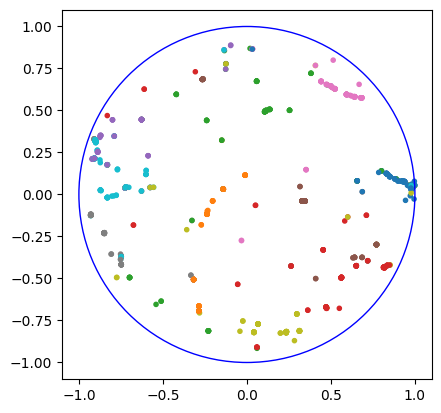

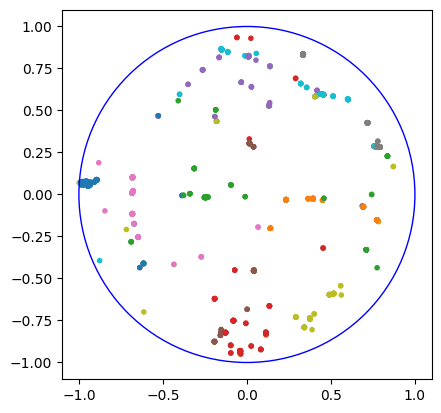

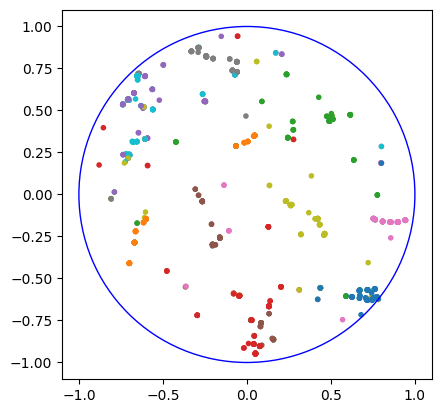

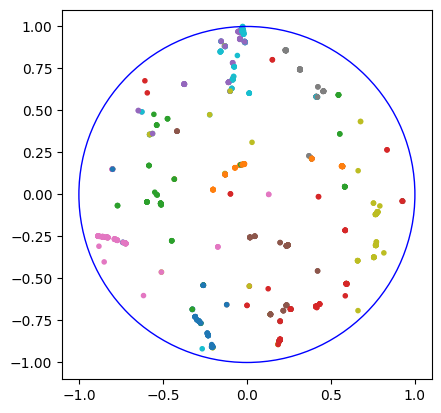

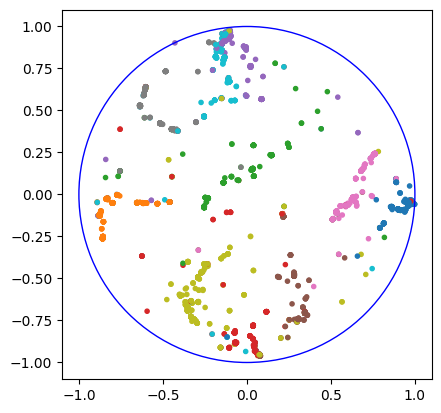

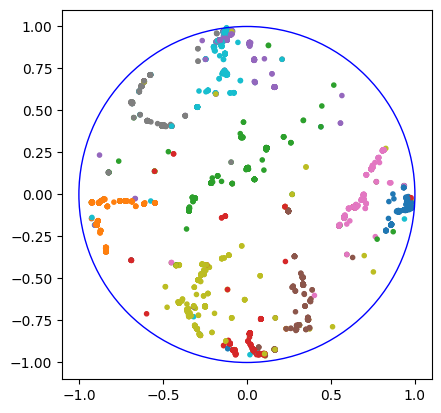

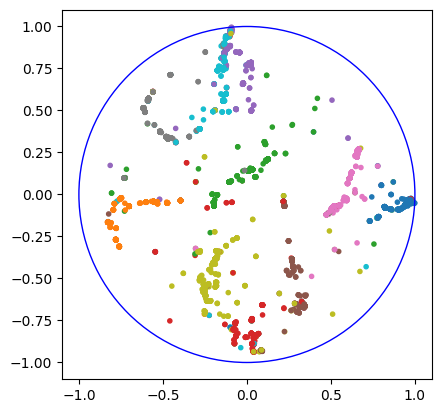

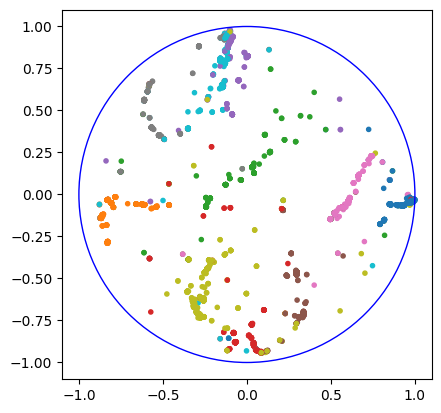

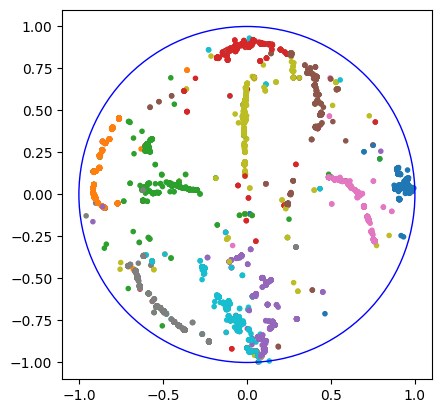

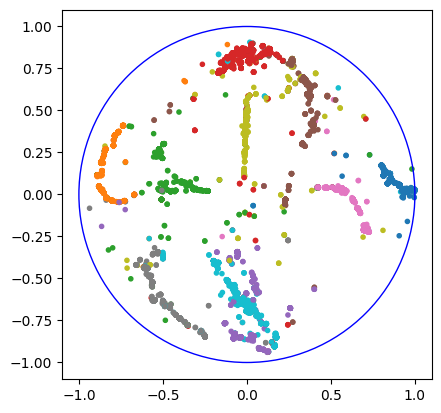

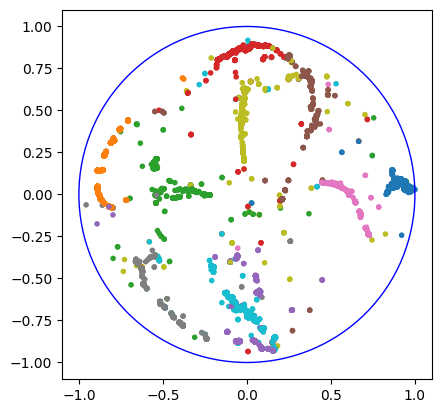

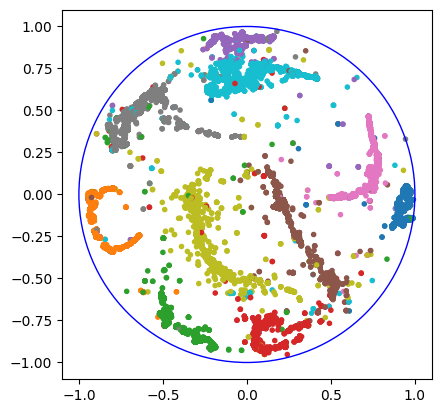

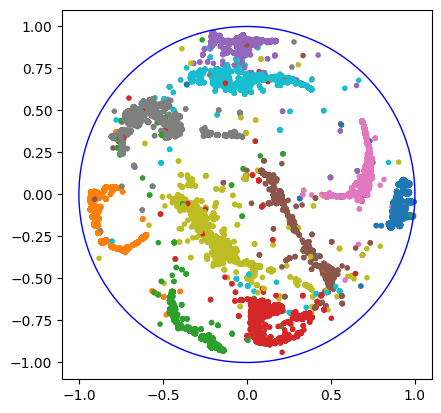

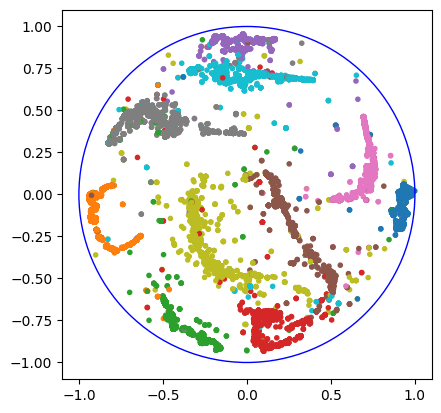

In [3]:
u_grid_ns = [10, 15, 20, 25, 30]
point_counts = [1000, 4000, 10000, 40000]
#u_grid_ns = [24]

exact_cpu_precisions = []
exact_cpu_recalls = []
exact_cpu_runtimes = []

exact_gpu_precisions = []
exact_gpu_recalls = []
exact_gpu_runtimes = []

ugrid_gpu_precisions = []
ugrid_gpu_recalls = []
ugrid_gpu_runtimes = []

qtree_cpu_precisions = []
qtree_cpu_recalls = []
qtree_cpu_runtimes = []

for num_points in point_counts:
    if (num_points <= 4000):
        p, r, t = run(num_points, True, False, 0) # Running exact CPU
        exact_cpu_precisions.append(p)
        exact_cpu_recalls.append(r)
        exact_cpu_runtimes.append(r)

    p, r, t = run(num_points, True, True, 0) # Running exact GPU
    exact_gpu_precisions.append(p)
    exact_gpu_recalls.append(r)
    exact_gpu_runtimes.append(r)

    p, r, t = run(num_points, False, True, 40) # Running approx. using uniform grid
    ugrid_gpu_precisions.append(p)
    ugrid_gpu_recalls.append(r)
    ugrid_gpu_runtimes.append(r)

    p, r, t = run(num_points, False, False, 0) # Running approx. using quadtree
    qtree_cpu_precisions.append(p)
    qtree_cpu_recalls.append(r)
    exact_cpu_runtimes.append(r)

#for u_grid_n in u_grid_ns:
#    p, r = run(1000, False, True, u_grid_n) # Running approx. using uniform grid
#    ugrid_gpu_precisions.append(p)
#    ugrid_gpu_recalls.append(r)

Exact CPU:
Precisions: [[0.82, 0.804, 0.7903333333333332, 0.7715, 0.7492000000000001, 0.7311666666666666, 0.7115714285714285, 0.698, 0.6802222222222222, 0.6687000000000001, 0.6545454545454545, 0.645, 0.6324615384615384, 0.619, 0.6075333333333333, 0.5949375, 0.5836470588235294, 0.5720555555555555, 0.5621052631578948, 0.5509000000000001, 0.540952380952381, 0.5315, 0.5210434782608695, 0.51075, 0.50112, 0.4918461538461538, 0.4840740740740741, 0.47617857142857145, 0.46551724137931033, 0.4570333333333333], [0.655, 0.627, 0.6040833333333333, 0.588625, 0.574, 0.561, 0.5492142857142857, 0.53675, 0.5259166666666666, 0.514575, 0.5047272727272727, 0.49575, 0.4864230769230769, 0.4781071428571429, 0.46953333333333336, 0.46190625, 0.4543088235294117, 0.44711111111111107, 0.44011842105263155, 0.4338, 0.42740476190476195, 0.42109090909090907, 0.4152282608695652, 0.4094895833333333, 0.4035300000000001, 0.3975480769230769, 0.3924259259259259, 0.38717857142857137, 0.3821379310344828, 0.37710000000000005]]

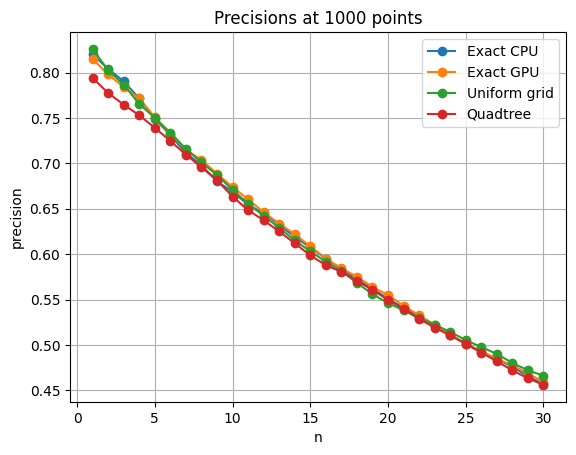

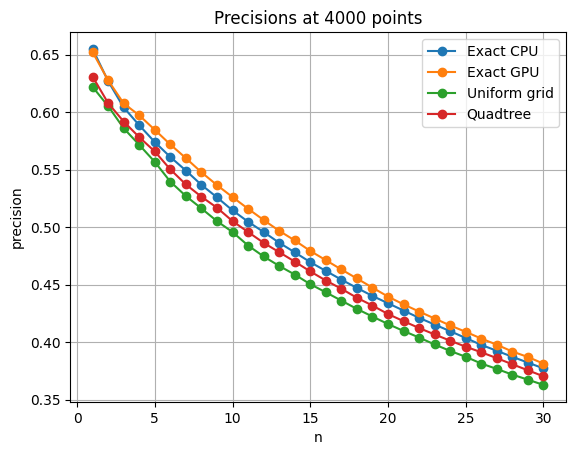

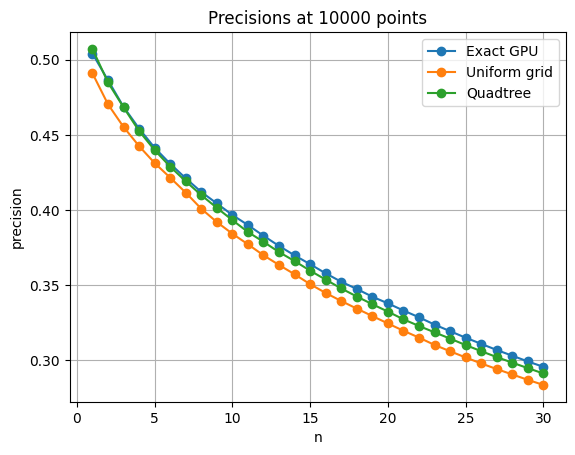

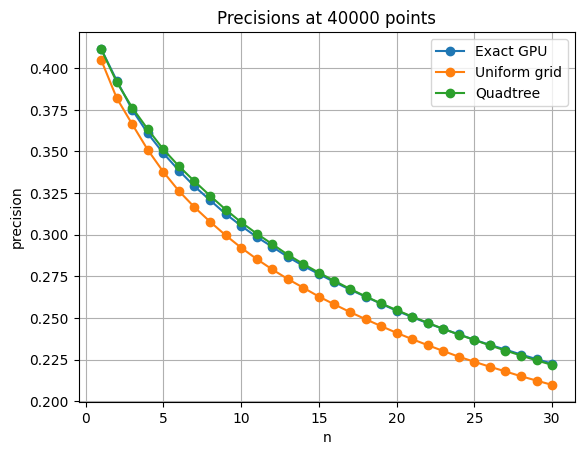

In [7]:
def plot_points(datas, labels, label, x_label, y_label):
    
    for data in datas:
        x = range(1, len(data) + 1)  # x-axis values from 1 to n
        plt.plot(x, data, marker='o', linestyle='-')  # Plot points connected by a line

    plt.legend(labels)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.grid(True)
    plt.show()

print("Exact CPU:")
print(f"Precisions: {exact_cpu_precisions}")
print(f"Recalls: {exact_cpu_recalls}")

print("Exact GPU:")
print(f"Precisions: {exact_gpu_precisions}")
print(f"Recalls: {exact_gpu_recalls}")

print("Uniform grid:")
print(f"Precisions: {ugrid_gpu_precisions}")
print(f"Recalls: {ugrid_gpu_recalls}")

print("Quadtree:")
print(f"Precisions: {qtree_cpu_precisions}")
print(f"Recalls: {qtree_cpu_recalls}")

data = [exact_cpu_precisions[0], exact_gpu_precisions[0], ugrid_gpu_precisions[0], qtree_cpu_precisions[0]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[0]} points", "n", "precision")

data = [exact_cpu_precisions[1], exact_gpu_precisions[1], ugrid_gpu_precisions[1], qtree_cpu_precisions[1]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[1]} points", "n", "precision")

data = [exact_gpu_precisions[2], ugrid_gpu_precisions[2], qtree_cpu_precisions[2]]
labels = ["Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[2]} points", "n", "precision")

data = [exact_gpu_precisions[3], ugrid_gpu_precisions[3], qtree_cpu_precisions[3]]
labels = ["Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, f"Precisions at {point_counts[3]} points", "n", "precision")